In [1]:
%gui qt5

# Notebook use to analyse one specific file.

You can click `shift` + `enter` to run one cell, you can also click run in top menu.
To run all the cells, you can click `kernel` and `Restart and run all` in the top menu.

In [2]:
# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# Ignore warnings in notebook
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Matplotlib to plot the data
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = 12,12
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
import napari

In [7]:
# Some module needed in the notebook
import numpy as np
import javabridge
import bioformats
from itkwidgets import view
from sklearn.externals import joblib

### The following path should direct to the folder "utils", on Window env it should have slash " / " and not backslash " \ " . 

In [8]:
# Create a temporary python PATH to the module that we are using for the analysis
import sys
sys.path.insert(0, "/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/utils")

In [9]:
from chromosome_dsb import *

In [10]:
# Need to create a javabridge to use bioformats to open proprietary format
javabridge.start_vm(class_path=bioformats.JARS)

### In the path_data variable you should enter the path to your data:

In [ ]:
path_data = '/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/data_chloe/cku-exo1_002/'

In [ ]:
position, time_point = load_data.stage_position(path_data)

# Set Parameters

In [90]:
# Size kernel for background substraction, should be a little larger than the object of interest
back_sub_FOCI = 5
back_sub_Nucleus = 20
# LOCI detection:
# Smallest object (in pixels) to be detected
smaller = 1
# Largest object to be detected
largest = 5
# Threshold above which to look for
threshold = 18000    

# Find "Skeleton" of gonad

In [ ]:
skelete = load_data.skeleton_coord(position,time_point)

# Load Image

### In the path_img you can enter the name of your specific image "/....dv"

In [11]:
path_img = '/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/data_chloe/2019-09-16_CG015_mpiMSH5_rbtGFP_chkHTP3_AV630_001_visit_17_D3D_ALX.dv'

In [12]:
image, meta, directory = load_data.load_bioformats(path_img)

In [13]:
print("image type:", image.dtype)
print("image shape:", image.shape)
print("image min:", image.min())
print("image max:", image.max())

image type: float64
image shape: (61, 480, 480, 4)
image min: -549.7520751953125
image max: 262525.875


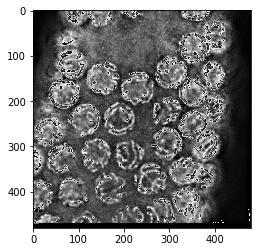

In [14]:
plt.imshow(image[32,:,:,3].astype("uint16"))

In [15]:
image.nbytes * 0.000001

449.7408

# Plot "Skeleton" of gonad

In [ ]:
data = np.concatenate((position,time_point[:, np.newaxis]), axis=1)
sort_data = data[np.argsort(data[:,2])]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(skelete[:,0], skelete[:,1], s=0.5)
stage_pos = ax.scatter(sort_data[:,0], sort_data[:,1])
working_on = ax.scatter(meta["PositionX"], meta["PositionY"], s=300, color = "r")
plt.legend([stage_pos, working_on], ["Stage Positions", 
                                     "Image currently working on"],
                                      loc=0,fontsize='large')
#plt.savefig('/Users/Espenel/Desktop/skeleton.png', bbox_inches="tight", pad_inches=0)

In [16]:
img = image[:,:,:,3]

In [ ]:
img.nbytes * 0.000001

In [105]:
viewer = napari.Viewer(ndisplay=3)

In [106]:
viewer.add_image(image[:,:,:,3])

<Image layer 'Image' at 0x16871fe10>

In [ ]:
#Nucleus_ch_norm = (Nucleus_ch - np.mean(Nucleus_ch)) / (np.max(Nucleus_ch) - np.min(Nucleus_ch))

In [ ]:
#Nucleus_ch_norm.min()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(np.amax(img, axis=0), vmin = 10000, vmax = 100000, cmap = "viridis")
ax.axis('off')
#plt.savefig('/Users/Espenel/Desktop/ImageXD2019/overlap_nucleus.png')

### Optionally you can visualyze your data

In [ ]:
#view(visualization.convert_view(img))

# Find the nucleus in the image

### First need to load the classifier (clf) and scaler.

In [ ]:
def compute_window_mean_and_var(image, window_w, window_h):
    w, h = image.shape
    w_new, h_new = w - window_w + 1, h - window_h + 1
    means = np.zeros([w_new, h_new])
    maximums = np.zeros([w_new, h_new])
    variations = np.zeros([w_new, h_new])
    for i in range(w_new):
        for j in range(h_new):
            window = image[i:i+window_w, j:j+window_h]
            means[i, j] = np.mean(window)
            maximums[i, j] = np.max(window) 
            variations[i, j] = np.var(window) 
    return means, maximums, variations    

In [ ]:
def compute_window_mean_and_var_strided(image, window_w, window_h):
    w, h = image.shape
    strided_image = np.lib.stride_tricks.as_strided(image, 
                                                    shape=[w - window_w + 1, h - window_h + 1, window_w, window_h],
                                                    strides=image.strides + image.strides)
    # important: trying to reshape image will create complete 4-dimensional compy
    means = strided_image.mean(axis=(2,3)) 
    mean_squares = (strided_image ** 2).mean(axis=(2, 3)) 
    maximums = strided_image.max(axis=(2,3))
    
    variations = mean_squares - means ** 2
    return means, maximums, variations    



In [ ]:
image_t = np.random.random([500, 500])

In [ ]:
window_w = 20
window_h = 20

In [ ]:
w, h = image_t.shape
strided_image = np.lib.stride_tricks.as_strided(image_t, 
                                                    shape=[w - window_w + 1, h - window_h + 1, window_w, window_h],
                                                    strides=image_t.strides + image_t.strides)

In [ ]:
strided_image.shape

In [ ]:
%time a1, b1, c1 = compute_window_mean_and_var(image_t, 20, 20)

In [ ]:
%time a2, b2, c2 = compute_window_mean_and_var_strided(image_t, 20, 20)

In [17]:
clf = joblib.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/clf_scaler/clf")
scaler = joblib.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/clf_scaler/scaler")

In [18]:
from skimage import util

In [19]:
import numpy as np
from skimage.feature import hog
from skimage.draw import ellipsoid
from skimage import util
import joblib
from skimage import morphology
from skimage import measure

In [20]:
def _task_predict(window, clf, scaler):
    im = hog(window, orientations=8, pixels_per_cell=(6, 6), block_norm = 'L2-Hys',
                                    cells_per_block=(3, 3), visualize=False, multichannel=False)
    X_img = scaler.transform(im.reshape(1, -1))
    res = clf.predict_proba(X_img)
    return(res[:,1])

In [71]:
def go_fast(img, clf, scaler):
    size = 70
    size_z = 1
    z, h, w = img.shape
    zz, hh, ww = z - size_z + 1, h - size + 1, w - size + 1

    #patch_proba = np.empty((mm, nn))
    #for i in range(0, mm, 4):
    #    for j in range(0, nn, 4):
    #        patch_proba[i, j] = _task_predict(img[0][i: i+size, j: j+size], clf=clf, scaler=scaler)
    list_proba = joblib.Parallel(n_jobs=-1)(joblib.delayed(_task_predict)(img[k,i: i+size, j: j+size], 
                                                           clf=clf, 
                                                           scaler=scaler) for k in range(0, zz, 2)
                                                                          for i in range(0, hh, 4)
                                                                          for j in range(0, ww, 4))
    #return patch_proba
    return list_proba


In [72]:
import time

In [73]:
t1 = time.time()
patch_proba = go_fast(img, clf= clf, scaler= scaler)
t2 = time.time()

In [76]:
(t2-t1)/60

17.208854150772094

In [77]:
len(patch_proba)

328879

In [79]:
30*103*103

318270

In [80]:
array_proba = np.asarray(patch_proba).reshape(31, 103,103)

In [81]:
size = 70
z, m, n = img.shape
mm, nn = m - size + 1, n - size + 1

In [82]:
patch_proba_empty = np.zeros((z, mm, nn))

In [83]:
patch_proba_empty[::2,::4,::4] = array_proba

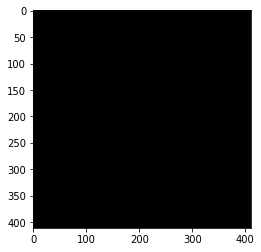

In [85]:
plt.imshow(patch_proba_empty[25])

In [ ]:
rol_view = util.view_as_windows(img[0], (70,70), step=(4))

In [ ]:
rol_view.shape

In [ ]:
t1 = time.time()
list_proba_2 = joblib.Parallel(n_jobs=-1)(joblib.delayed(_task_predict)(rol_view[i,j], 
                                                           clf=clf, 
                                                           scaler=scaler) for i in range(103)
                                                                          for j in range(103))
t2 = time.time()                                           

In [ ]:
print(t2-t1)

In [ ]:
window_w = 70
window_h = 70

In [ ]:
w, h = img[0].shape
strided_image = np.lib.stride_tricks.as_strided(img[0], 
                                                    shape=[w - window_w + 1, h - window_h + 1, window_w, window_h],
                                                    strides=img[0].strides + img[0].strides)

In [ ]:
strided_image.shape

In [ ]:
rol_view[0,100,150,0].shape

In [ ]:
rol_view = util.view_as_windows(img, (1,70,70), step=1)

In [ ]:
list_proba = joblib.Parallel(n_jobs=-1)(joblib.delayed(_task_predict)(rol_view[i,j,k,0], clf, scaler) for i in range(61) for j in range(411) for k in range(411))

In [ ]:
list_proba

In [ ]:
img.shape

In [ ]:
rol_view.shape

In [ ]:
plt.imshow(img[0])

In [ ]:
plt.imshow(rol_view[0,100,150,0])

In [ ]:
import time

In [ ]:
tp_1 = time.time()
result = search.rolling_window(img, clf, scaler, stepSize=4, Zstep =2)
tp_2 = time.time()
print(tp_2-tp_1)

In [86]:
result = np.copy(patch_proba_empty)

In [275]:
bbox_ML = search.non_max_suppression(result, probaThresh=0.8, overlapThresh=0.2)

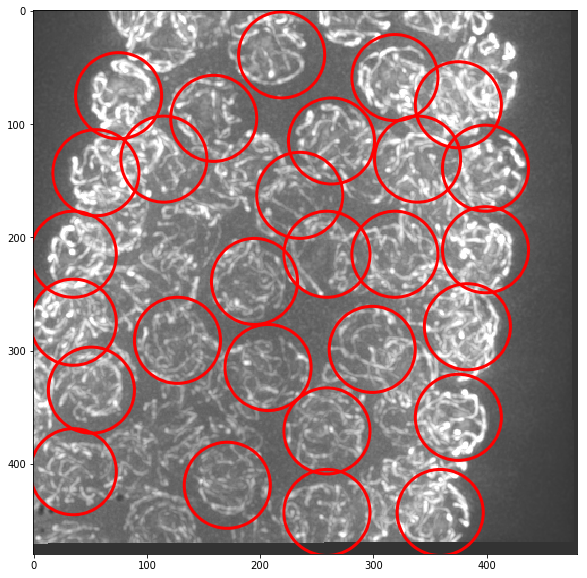

In [276]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.amax(img,axis=0), vmax=img.max()/2, alpha = 0.8)
for coord in bbox_ML:
    circles1 = patches.Circle((coord[0]+35,coord[1]+35),38, linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(circles1)

# Background Substraction

In [92]:
FOCI_ch, _ = img_analysis.background_correct(image, ch=1, size=back_sub_FOCI)
Nucleus_ch, _ = img_analysis.background_correct(image, ch=3, size=back_sub_Nucleus)

In [93]:
visualization.plot_background(image, FOCI_ch, Nucleus_ch)

interactive(children=(IntSlider(value=100, description='pos', max=479), Dropdown(description='channel', option…

# Finding the Blobs/FOCI

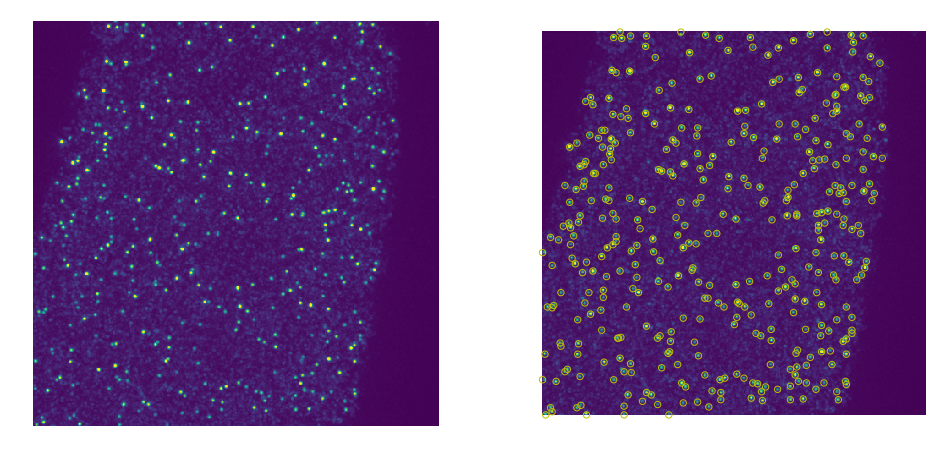

In [94]:
blobs = img_analysis.find_blob(FOCI_ch, meta, directory, smaller = smaller, 
                               largest = largest, thresh = threshold,
                               plot=True, save=True)

In [108]:
viewer.add_points(blobs[:,0:3], size =7, face_color='blue')

<Points layer 'Points' at 0x16871fb50>

In [96]:
from skimage.draw import ellipsoid
def _binary(box, image):
    ellip_base = ellipsoid(37, 37, 37, spacing=(1.05, 1.05, 2.1), levelset=False).astype("int")

    pts = np.transpose(np.nonzero(ellip_base))
    z,x,y = image.shape
    # Need to add some extra padding around the z axis
    binary = np.zeros((x, y, z+30))
    for i in range(len(box)):
        binary[pts[:,0]+(box[i,1]).astype(int),
               pts[:,1]+(box[i,0]).astype(int),
               pts[:,2]+box[i,4].astype(int)] = i

    #Remove extra padding
    return(binary[:,:,15:z+15].transpose(2,0,1))

# Could probably just use the binary image of ellipsoid as a mask to find number of FOCI per nucleus

In [ ]:
bbox_ML[0,1]

In [ ]:
bowl = _binary(bbox_ML, img)

In [ ]:
blobs

In [ ]:
from skimage import morphology

In [ ]:
blob_im = np.zeros(FOCI_ch.shape, dtype=np.int)
blob_im[(blobs[:,0]).astype(np.int),
        (blobs[:,1]).astype(np.int),
        (blobs[:,2]).astype(np.int)] = np.arange(len(blobs[:,1])) + 1
#dilated = morphology.dilation(blob_im, morphology.ball(3))

In [ ]:
from skimage import measure

In [ ]:
prop = measure.regionprops(bowl.astype('int'), intensity_image = blob_im)

In [ ]:
for pro in prop:
    #plt.imshow(np.amax(pro['intensity_image'],axis=0))
    print(len(np.where(pro['intensity_image']>0)[0]))

In [ ]:
viewer.add_labels(bowl)

In [ ]:
bowl.shape

# Binarization of the Channel with nucleus

In [97]:
binary = img_analysis.binarization(Nucleus_ch)

In [109]:
viewer.add_labels(binary)

<Labels layer 'Labels' at 0x16936e550>

In [110]:
viewer.add_points(np.flip(bbox_ML[:,0:2])+30, size =70, edge_color='red', face_color='black')

<Points layer 'Points 1' at 0x175c599d0>

### Optionaly, you can visualyze the result of the binarization

In [ ]:
#view(visualization.convert_view(binary))

# Load the position of the different nucleus

In [ ]:
#bbox_ML = np.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/13/bbox_3D.npy")

# Mask FOCI that are not on the nucleus

In [265]:
t1 = time.time()
masked = search.find_foci(blobs, FOCI_ch, Nucleus_ch, binary, bbox_ML)
t2 = time.time()

(61, 480, 480)
(495, 495, 91)


# Mask FOCI that are not on a nucleus found by the Machine Learning

In [100]:
t3 = time.time()
masked = search.find_foci_bis(blobs, FOCI_ch, Nucleus_ch, bbox_ML)
t4 = time.time()

# Problem, I am not counting dot that touch the ellipsoid...Could probably just label the ellipsoid and then find number of blob per ellipsoid.
# The problem might be because of the step size of 8...

In [ ]:
liste = []
box_mask = []
for i in range(len(bbox_ML)):
    binary = np.zeros((x, y, z+30))
    mask = np.copy(masked)
    #create elipsoid where Chromosome where found
    binary[pts[:,0]+box[i,1].astype(int),
           pts[:,1]+box[i,0].astype(int),
           pts[:,2]+box[i,4].astype(int)] = 1
    binary = binary[:,:,15:z+15].transpose(2,0,1)
    # remove every dots that are not on a chromosome

    if len(np.where(mask>0)[0]) == 0:
        liste.append(np.array([[np.nan,np.nan,np.nan,i]]))
        box_mask.append(False)
    else:
        box_mask.append(True)
        liste.append(np.squeeze(np.dstack((np.where(mask>0)[0],
                                np.where(mask>0)[1],
                                np.where(mask>0)[2],
                                np.full(len(np.where(mask>0)[0]), i)))))

In [ ]:
t2-t1

In [ ]:
t4-t3

In [268]:
res, bb_mask = search.binary_select_foci(bbox_ML, Nucleus_ch, masked)

In [196]:
bbox_ML.T.shape

(5, 26)

In [197]:
bbox_trans = np.empty((26,3))

In [210]:
bbox_trans[:,0] = bbox_ML[:,4]
bbox_trans[:,1] = bbox_ML[:,1]+35
bbox_trans[:,2] = bbox_ML[:,0]+35

In [211]:
viewer.add_points(bbox_trans, size =7, face_color='blue')

<Points layer 'Points 4' at 0x169ba1750>

In [262]:
binary_elli = search._binary(bbox_ML, Nucleus_ch)

(61, 480, 480)
(495, 495, 91)


In [263]:
binary_elli.shape

(61, 480, 480)

In [264]:
viewer.add_labels(binary_elli)

<Labels layer 'Labels 3' at 0x16c808ad0>

# Find and remove FOCI that were counted twice

In [269]:
num, cts, dup_idx, mask = search.find_duplicate(res, bb_mask)

In [140]:
dup_idx

[array([82, 90])]

In [141]:
z,x,y = np.where(masked)

In [142]:
viewer.add_points(np.squeeze(np.dstack((z, x,y))), size =15, face_color='red')

<Points layer 'Points 5' at 0x16c8891d0>

(-26.101947090867682, 479.5, 505.35588252393757, -26.35587380200379)

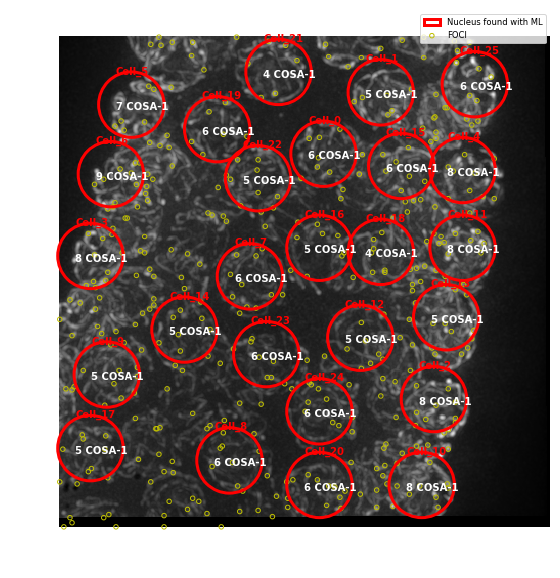

In [270]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.amax(img,axis=0), vmax=img.max())
for blob in blobs:
    z,x,y,s = blob
    loci = ax.scatter(y, x, s=20, facecolors='none', edgecolors='y')
for coord, val, cell in zip(bbox_ML,cts, num):
    if val == 0:
        circles1 = patches.Circle((coord[0]+30,coord[1]+30),32, linewidth=3,edgecolor='r',facecolor='none', alpha = 0.2)
    elif val > 0:
        circles1 = patches.Circle((coord[0]+30,coord[1]+30),32, linewidth=3,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(circles1)
    ax.text(coord[0]+15,coord[1], "Cell_{}".format(str(cell)),color = 'r', weight='bold')
    ax.text(coord[0]+15,coord[1]+35, "{} COSA-1".format(str(val)),color = 'w', weight='bold')
plt.legend([circles1, loci], ["Nucleus found with ML",  "FOCI"],loc=1,fontsize='small')
plt.axis('off')
#plt.savefig('/Users/Espenel/Desktop/ImageXD2019/result.png')

(-26.101947090867682, 479.5, 505.35588252393757, -26.35587380200379)

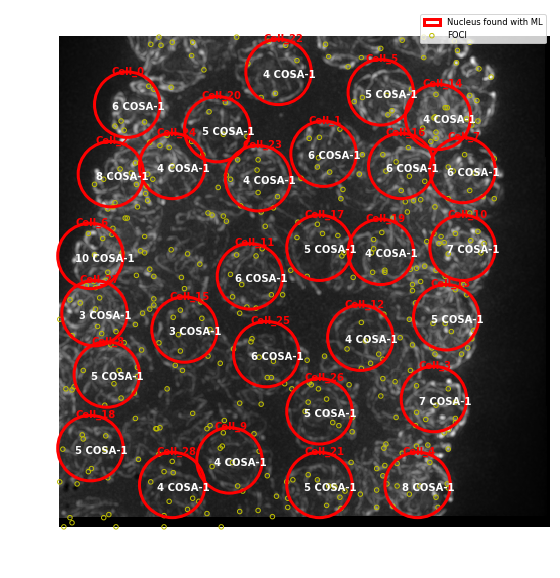

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.amax(img,axis=0), vmax=img.max())
for blob in blobs:
    z,x,y,s = blob
    loci = ax.scatter(y, x, s=20, facecolors='none', edgecolors='y')
for coord, val, cell in zip(bbox_ML,cts, num):
    if val == 0:
        circles1 = patches.Circle((coord[0]+30,coord[1]+30),32, linewidth=3,edgecolor='r',facecolor='none', alpha = 0.2)
    elif val > 0:
        circles1 = patches.Circle((coord[0]+30,coord[1]+30),32, linewidth=3,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(circles1)
    ax.text(coord[0]+15,coord[1], "Cell_{}".format(str(cell)),color = 'r', weight='bold')
    ax.text(coord[0]+15,coord[1]+35, "{} COSA-1".format(str(val)),color = 'w', weight='bold')
plt.legend([circles1, loci], ["Nucleus found with ML",  "FOCI"],loc=1,fontsize='small')
plt.axis('off')
#plt.savefig('/Users/Espenel/Desktop/ImageXD2019/result.png')

In [ ]:
visualization.plot_result(img, blobs, bbox_ML,\
                          cts, num, meta, directory, save = False)

In [ ]:
from sklearn.neighbors import KDTree

In [ ]:
tree = KDTree(skelete)

In [ ]:
tree

In [ ]:
coords = np.copy(bbox_ML[:,0:2])
coords[:,0] = (coords[:,0]+35)*meta['PhysicalSizeX'] + meta['PositionX']-19
coords[:,1] = (480 - (coords[:,1]+35))*meta['PhysicalSizeY'] + meta['PositionY']-19

In [ ]:
data = np.concatenate((position,time_point[:, np.newaxis]), axis=1)
sort_data = data[np.argsort(data[:,2])]

fig, ax = plt.subplots(1, 1, figsize=(5, 10))
ax.scatter(skelete[:,0], skelete[:,1], s=0.5)
ax.scatter(coords[:,0], coords[:,1], c='g')
stage_pos = ax.scatter(sort_data[:,0], sort_data[:,1])
#working_on = ax.scatter(meta["PositionX"], meta["PositionY"], s=300, color = "r")
#plt.legend([stage_pos, working_on], ["Stage Positions", 
#                                     "Image currently working on"],
#                                      loc=0,fontsize='large')
plt.savefig('/Users/Espenel/Desktop/skeleton_1.png', bbox_inches="tight", pad_inches=0)

In [ ]:
dist_tip = img_analysis.distance_to_tip(bbox_ML, skelete, meta)

In [ ]:
chro_pos = np.squeeze(np.dstack((bbox_ML[:,0]+35,
                          bbox_ML[:,1]+35, bbox_ML[:,4])))

In [ ]:
df = img_analysis.final_table(meta, bbox_ML,  \
                         dist_tip, cts, num, \
                         directory, save = False)

In [ ]:
df

In [ ]:
to_save = {'back_sub_ch1' : back_sub_FOCI,
           'back_sub_ch2' : back_sub_Nucleus,
           'small_object' : smaller,
           'large_object' : largest,
           'threshold' : threshold}

log.log_file(directory, meta, **to_save)

In [ ]:
tp2 = time.time()

In [ ]:
print("It took {}sec".format(int(tp2-tp1)))